In [21]:
import tensorflow_mri as tfmr
import numpy as np
from sklearn.model_selection import train_test_split
from glob import glob
import tensorflow as tf
import tensorflow.keras.backend as K
import random
import matplotlib.pyplot as plt
from skimage import exposure
import scipy
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import neptune
from neptune.new.integrations.tensorflow_keras import NeptuneCallback

continue_training = True
model_name = 'AOR-35'

/usr/local/lib/python3.8/dist-packages/neptune/internal/backends/hosted_client.py:50: NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/
  from neptune.version import version as neptune_client_version
/tmp/ipykernel_3277098/2858174319.py:2: NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
  from neptune.new.integrations.tensorflow_keras import NeptuneCallback


This is only to visulise the images in data loader

In [3]:
if continue_training:
    run = neptune.init_run(
        project="Aorta/Aorta-raw",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzMjE2ZWMxNi04ZjNkLTRjYjctYWQ1Ni1mY2EyNTU2ZGViYTMifQ==",
        with_id = model_name)  

else:
    run = neptune.init_run(
        project="Aorta/Aorta-raw",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzMjE2ZWMxNi04ZjNkLTRjYjctYWQ1Ni1mY2EyNTU2ZGViYTMifQ==",
    )  # your credentials
    model_name = list(run.__dict__.values())[-6]

/tmp/ipykernel_3020204/625125474.py:2: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  run = neptune.init_run(


https://app.neptune.ai/Aorta/Aorta-raw/e/AOR-35


In [4]:
patients = [pat.replace('.npy','') for pat in glob('data/Karan_81/*')] 
train_patients, val_patients = train_test_split(patients,test_size=0.2)

In [5]:
len(train_patients) # (64:17)

64

In [6]:
class CustomDataGen():    
    def __init__(self, patients, cohort):
        random.shuffle(patients)
        self.patients = patients
        self.cohort = cohort                
    def data_generator(self):
        for patient in self.patients:
            image_mask = np.load(f"{patient}.npy")
            image = image_mask[...,0]
            mask = image_mask[...,1]
            image=normalize(image)
            image= aug_down_gamma_up(image)
            image=image[...,np.newaxis]
            mask=mask[...,np.newaxis]
            bkg = np.zeros(mask.shape[:2])
            bkg = np.where(np.sum(mask,-1) == 1, 0, 1)
            mask = np.concatenate([bkg[...,np.newaxis],mask], -1)
            image=normalize(image)
            yield image, mask.astype('uint8')           
    def get_gen(self):
        return self.data_generator() 	 
          
def normalize(image):
    mean = np.mean(image)
    std = np.std(image)
    if std != 0:
        norm = (image - mean) / std
    else:
        norm = np.zeros_like(image)
    return norm

def random_gamma(img2):
    num_slice = random.randint(0, 3) 
    if num_slice != 0:
        start_slice = random.randint(0, img2.shape[0] - 4)
        selected_slices = list(range(start_slice, start_slice + num_slice))
        #print(selected_slices) 
        for i in range(num_slice):
            slice_i = img2[selected_slices[i], :, :]
            slice_i = np.clip(slice_i, 0, None)
            gamma=round(np.random.beta(1, 5) * 0.2 + 0.5, 1) 
            ad_slice = exposure.adjust_gamma(slice_i, gamma)
            img2[selected_slices[i], :, :] = ad_slice
    return img2

def random_dark(image):
    num_slice = random.randint(0, 2) 
    if num_slice != 0:
        start_slice = random.randint(0, image.shape[0] - 5)
        selected_slices = list(range(start_slice, start_slice + num_slice))
        #print(selected_slices)
        for i in range(num_slice):
            slice_i = image[selected_slices[i], :, :]
            slice_i = np.clip(slice_i, 0, None)
            gamma=round(random.uniform(1.2, 1.7), 1) 
            ad_slice = exposure.adjust_gamma(slice_i, gamma)
            image[selected_slices[i], :, :] = ad_slice
    return image

def aug_down_gamma_up(image):
    adj_image=scipy.ndimage.zoom(image, (1/7.2,1,1), order=1, mode='constant')
    gamma_image=random_gamma(adj_image)
    dark_image=random_dark(gamma_image)
    image3d=scipy.ndimage.zoom(dark_image, (7.2,1,1), order=3, mode='constant')
    #print(image3d.shape)
    return image3d

In [7]:
output_channel=2
batch_size = 1
input_shape = [None,None,None,1]
output_shape = [None,None,None,output_channel] #output channel=2

train_gen = CustomDataGen(train_patients, 'train').get_gen
val_gen   = CustomDataGen(val_patients, 'val').get_gen

output_signature = (tf.TensorSpec(shape=input_shape, dtype=tf.float32), tf.TensorSpec(shape=output_shape, dtype=tf.float32))

train_ds = tf.data.Dataset.from_generator(train_gen, output_signature = output_signature)
val_ds = tf.data.Dataset.from_generator(val_gen, output_signature = output_signature)

train_ds = train_ds.shuffle(8, seed = 42, reshuffle_each_iteration=True).batch(batch_size).prefetch(-1)
val_ds = val_ds.batch(batch_size).prefetch(-1)

2023-09-09 18:46:13.718560: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-09 18:46:14.316766: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46706 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:3b:00.0, compute capability: 8.6


In [10]:
X, y = next(iter(train_ds))

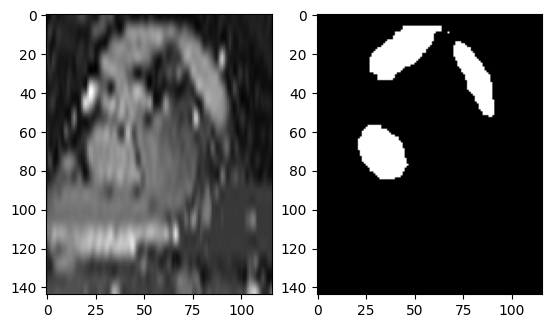

In [11]:
fig, axs = plt.subplots(1,2)
axs[0].imshow(X[0,...,51,0],cmap='gray')
axs[1].imshow(y[0,...,50,1],cmap='gray')   

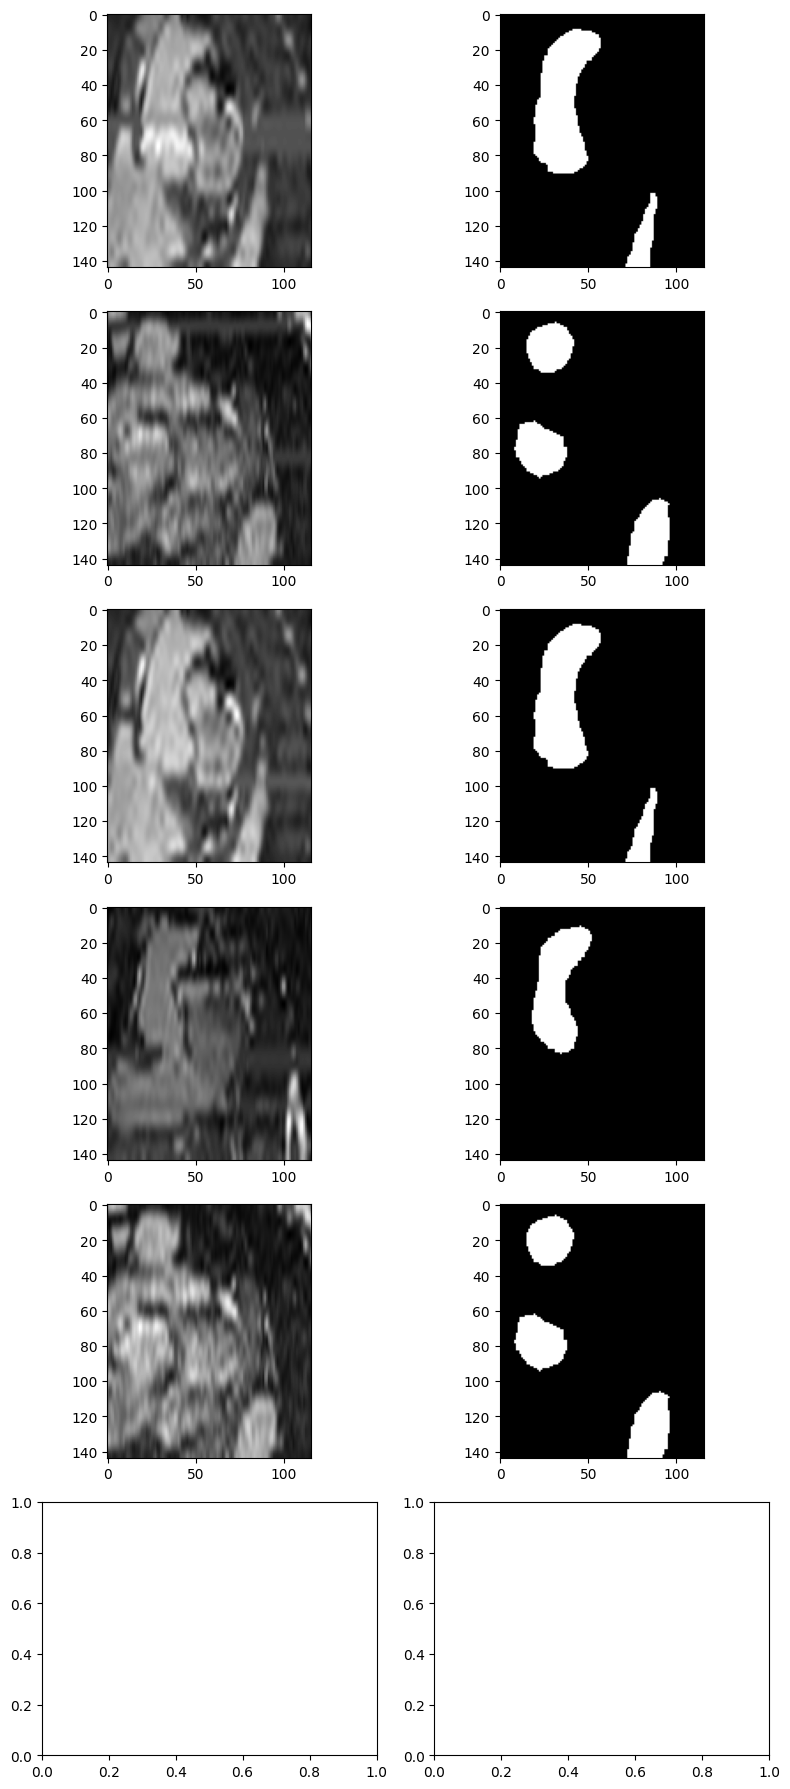

In [13]:
fig, axs = plt.subplots(6, 2, figsize=(8, 18))

for i in range(5):
    X, y = next(iter(train_ds))
    axs[i, 0].imshow(X[0, ..., 45, 0], cmap='gray')
    axs[i, 1].imshow(y[0, ..., 45, 1], cmap='gray')

plt.tight_layout()
plt.show()

(1, 144, 116, 96, 1)
(1, 144, 116, 96, 2)
(1, 144, 116, 96, 1)
(1, 144, 116, 96, 2)
(1, 144, 116, 96, 1)
(1, 144, 116, 96, 2)
(1, 144, 116, 96, 1)
(1, 144, 116, 96, 2)
(1, 144, 116, 96, 1)
(1, 144, 116, 96, 2)
(1, 144, 116, 96, 1)
(1, 144, 116, 96, 2)
(1, 144, 116, 96, 1)
(1, 144, 116, 96, 2)
(1, 144, 116, 96, 1)
(1, 144, 116, 96, 2)
(1, 144, 116, 96, 1)
(1, 144, 116, 96, 2)


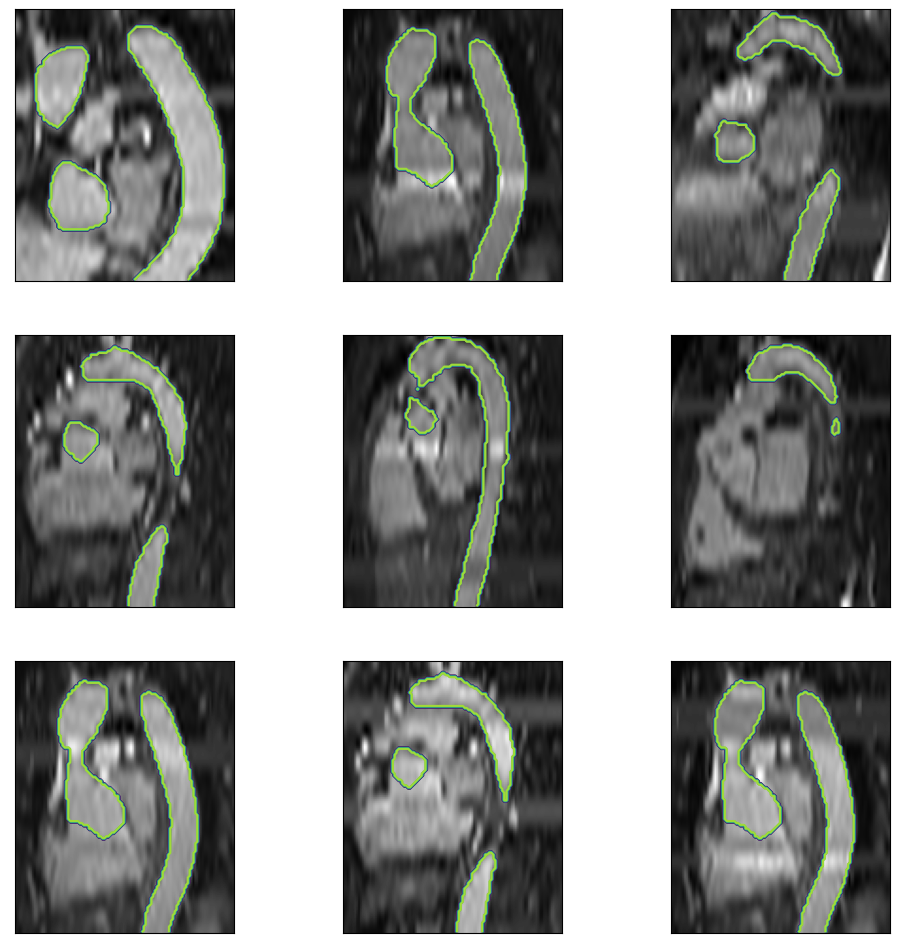

In [10]:
fig, ax = plt.subplots(3, 3, figsize=(12, 12))
for i in range(9):
  row, col = i // 3, i % 3
  X, y = next(iter(train_ds))
  ax[row, col].imshow(X[0,...,51,0],cmap='gray')
  ax[row, col].contour(y[0,...,51,1],corner_mask=False)
  print(X.shape)
  print(y.shape)
  ax[row, col].set_xticks([])
  ax[row, col].set_yticks([])
plt.show()

3020
3027


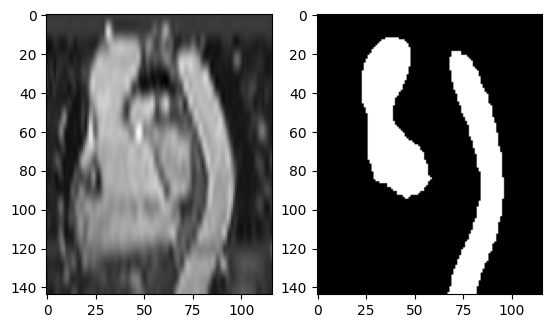

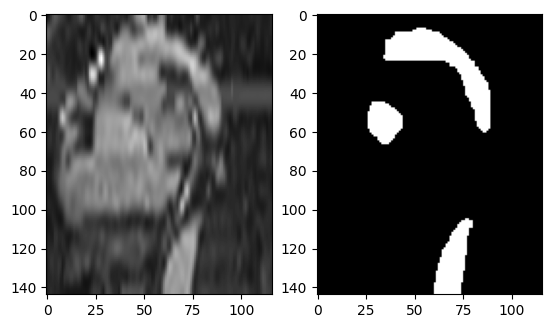

In [13]:
for patient in train_patients[:2]:
    gen = CustomDataGen([patient], 'train').get_gen
    ds = tf.data.Dataset.from_generator(gen, output_signature = output_signature)
    X, y = next(iter(ds))
    print(patient.split('/')[-1])
    fig, axs = plt.subplots(1,2)
    axs[0].imshow(X[...,50,0],cmap='gray')
    axs[1].imshow(y[...,50,1],cmap='gray')   

In [8]:
def iou(y_true, y_pred, dtype=tf.float32):
    # tf tensor casting
    y_pred = tf.convert_to_tensor(y_pred)
    y_pred = tf.cast(y_pred[...,1:], dtype)
    y_true = tf.cast(y_true[...,1:], y_pred.dtype)

    y_pred = tf.squeeze(y_pred)
    y_true = tf.squeeze(y_true)
    
    y_true_pos = tf.reshape(y_true, [-1])
    y_pred_pos = tf.reshape(y_pred, [-1])

    area_intersect = tf.reduce_sum(tf.multiply(y_true_pos, y_pred_pos))
    
    area_true = tf.reduce_sum(y_true_pos)
    area_pred = tf.reduce_sum(y_pred_pos)
    area_union = area_true + area_pred - area_intersect
    
    return tf.math.divide_no_nan(area_intersect, area_union)

def dice_coef(y_true, y_pred, const=K.epsilon()):
    
    # flatten 2-d tensors
    y_true_pos = tf.reshape(y_true[...,1:], [-1])
    y_pred_pos = tf.reshape(y_pred[...,1:], [-1])
    
    # get true pos (TP), false neg (FN), false pos (FP).
    true_pos  = tf.reduce_sum(y_true_pos * y_pred_pos)
    false_neg = tf.reduce_sum(y_true_pos * (1-y_pred_pos))
    false_pos = tf.reduce_sum((1-y_true_pos) * y_pred_pos)
    
    # 2TP/(2TP+FP+FN) == 2TP/()
    coef_val = (2.0 * true_pos + const)/(2.0 * true_pos + false_pos + false_neg)
    
    return coef_val


In [9]:
if continue_training:
    model = tf.keras.models.load_model(f'models/{model_name}', compile = False)
else:
    inputs = tf.keras.Input(shape = [None,None,None,1]) #define input_shape don't need to specify batch size
    tf.keras.backend.clear_session()
    model = tfmr.models.UNet3D (filters=[64,128,256],
                        kernel_size=3,
                        out_activation='softmax',
                        out_channels = output_channel,
                        use_batch_norm=True)

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(), metrics=[dice_coef,iou])

In [11]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='loss', 
                   mode='min', 
                   verbose = 1, 
                   patience = 10)
mc = ModelCheckpoint(f'models/{model_name}',
                  save_best_only= True,
                    monitor='val_loss',
                    mode='min')
neptune_callback = NeptuneCallback(run = run)
model.fit(train_ds,
          validation_data = val_ds, 
          epochs=30,
          callbacks=[es, mc, neptune_callback])
          
run['model'].upload(f'models/{model_name}')

Epoch 1/30


     64/Unknown - 48s 668ms/step - loss: 0.0129 - dice_coef: 0.8492 - iou: 0.7421

INFO:tensorflow:Assets written to: models/AOR-35/assets


INFO:tensorflow:Assets written to: models/AOR-35/assets


64/64 [==============================] - 65s 933ms/step - loss: 0.0129 - dice_coef: 0.8492 - iou: 0.7421 - val_loss: 0.0271 - val_dice_coef: 0.8364 - val_iou: 0.7222
Epoch 2/30
64/64 [==============================] - 60s 858ms/step - loss: 0.0127 - dice_coef: 0.8529 - iou: 0.7476 - val_loss: 0.0290 - val_dice_coef: 0.8291 - val_iou: 0.7111
Epoch 3/30
64/64 [==============================] - 60s 860ms/step - loss: 0.0117 - dice_coef: 0.8625 - iou: 0.7619 - val_loss: 0.0280 - val_dice_coef: 0.8478 - val_iou: 0.7382
Epoch 4/30
64/64 [==============================] - 60s 858ms/step - loss: 0.0128 - dice_coef: 0.8571 - iou: 0.7548 - val_loss: 0.0321 - val_dice_coef: 0.8411 - val_iou: 0.7281
Epoch 5/30
64/64 [==============================] - ETA: 0s - loss: 0.0112 - dice_coef: 0.8676 - iou: 0.7697

INFO:tensorflow:Assets written to: models/AOR-35/assets


INFO:tensorflow:Assets written to: models/AOR-35/assets


64/64 [==============================] - 65s 932ms/step - loss: 0.0112 - dice_coef: 0.8676 - iou: 0.7697 - val_loss: 0.0261 - val_dice_coef: 0.8588 - val_iou: 0.7546
Epoch 6/30
64/64 [==============================] - 61s 866ms/step - loss: 0.0105 - dice_coef: 0.8747 - iou: 0.7804 - val_loss: 0.0295 - val_dice_coef: 0.8441 - val_iou: 0.7321
Epoch 7/30
64/64 [==============================] - 61s 867ms/step - loss: 0.0108 - dice_coef: 0.8741 - iou: 0.7802 - val_loss: 0.0301 - val_dice_coef: 0.8430 - val_iou: 0.7313
Epoch 8/30
64/64 [==============================] - 60s 860ms/step - loss: 0.0119 - dice_coef: 0.8669 - iou: 0.7683 - val_loss: 0.0298 - val_dice_coef: 0.8592 - val_iou: 0.7552
Epoch 9/30
64/64 [==============================] - 60s 860ms/step - loss: 0.0107 - dice_coef: 0.8778 - iou: 0.7850 - val_loss: 0.0346 - val_dice_coef: 0.8572 - val_iou: 0.7522
Epoch 10/30
64/64 [==============================] - 60s 858ms/step - loss: 0.0101 - dice_coef: 0.8837 - iou: 0.7943 - val_los

ERROR:neptune.internal.operation_processors.async_operation_processor:Error occurred during asynchronous operation processing: Cannot upload file /workspaces/PhD/Unet3D_practice/models/AOR-35: Path not found or is a not a file.


In [12]:
if continue_training:
    model = tf.keras.models.load_model(f'models/{model_name}', compile = False)
print(model_name)

AOR-35


In [13]:
for layer in model.layers:
    print(layer.get_config())

{'filters': ListWrapper([64, 64]), 'kernel_size': 3, 'strides': 1, 'activation': 'relu', 'out_activation': 'same', 'use_bias': True, 'kernel_initializer': 'VarianceScaling', 'bias_initializer': 'Zeros', 'kernel_regularizer': None, 'bias_regularizer': None, 'use_batch_norm': True, 'use_sync_bn': False, 'bn_momentum': 0.99, 'bn_epsilon': 0.001, 'use_residual': False, 'use_dropout': False, 'dropout_rate': 0.3, 'dropout_type': 'standard'}
{'filters': ListWrapper([128, 128]), 'kernel_size': 3, 'strides': 1, 'activation': 'relu', 'out_activation': 'same', 'use_bias': True, 'kernel_initializer': 'VarianceScaling', 'bias_initializer': 'Zeros', 'kernel_regularizer': None, 'bias_regularizer': None, 'use_batch_norm': True, 'use_sync_bn': False, 'bn_momentum': 0.99, 'bn_epsilon': 0.001, 'use_residual': False, 'use_dropout': False, 'dropout_rate': 0.3, 'dropout_type': 'standard'}
{'filters': ListWrapper([256, 256]), 'kernel_size': 3, 'strides': 1, 'activation': 'relu', 'out_activation': 'same', 'us

In [14]:
patient = val_patients[3]
X_test = []
y_test = []
test_gen   = CustomDataGen([patient], 'test').get_gen()
for X, y in test_gen:
    X_test.append(X)
    y_test.append(y)
X_test = np.stack(X_test)
y_test = np.stack(y_test)

In [24]:
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

In [16]:
y_pred = model.predict(X_test)
y_pred = get_one_hot(np.argmax(y_pred,axis = -1), 3) #np.argmax return the indice of the max value of an array

1/1 [==============================] - 1s 614ms/step


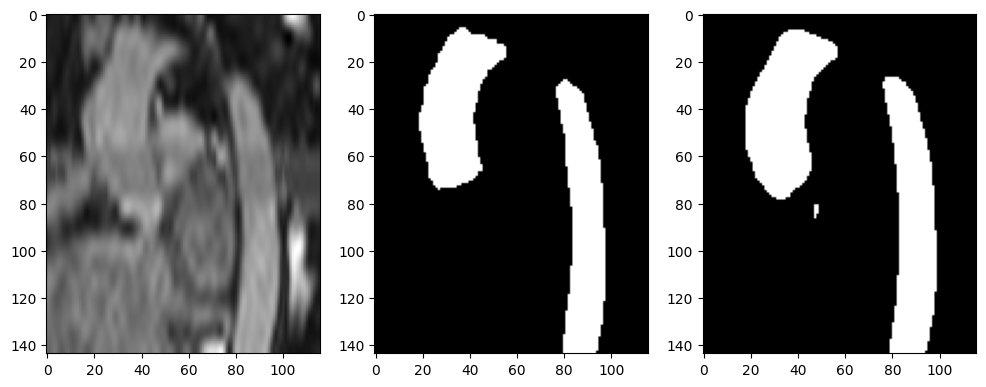

In [17]:
fig, axs = plt.subplots(1,3,figsize= (12,6))

i = 0
axs[0].imshow(X_test[i,...,47,0],cmap='gray')
axs[1].imshow(y_test[i,...,47,1],cmap='gray')
axs[2].imshow(y_pred[i,...,47,1],cmap='gray')

1/1 [==============================] - 0s 148ms/step


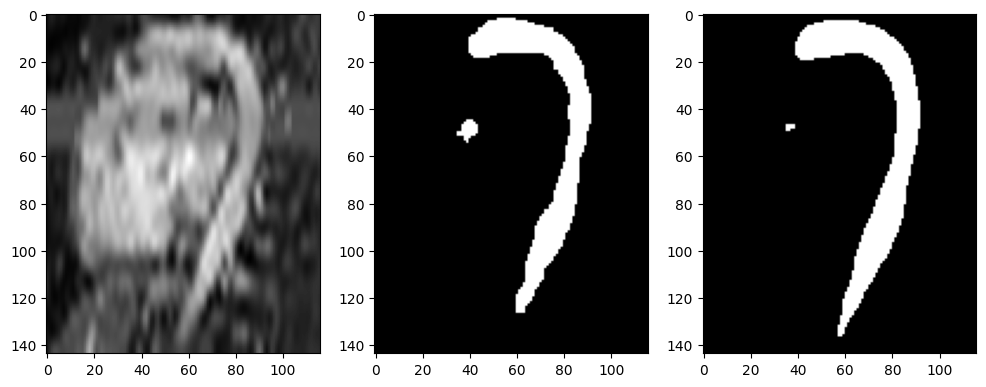

In [18]:
from matplotlib import animation
patient = 'data/Karan_37/2013'
X_test = []
y_test = []
test_gen   = CustomDataGen([patient], 'test').get_gen()
for X, y in test_gen:
    X_test.append(X)
    y_test.append(y)
X_test = np.stack(X_test)
y_test = np.stack(y_test)
y_pred = model.predict(X_test)
y_pred = get_one_hot(np.argmax(y_pred,axis = -1), 3)
fig, axs = plt.subplots(1,3, figsize= (12,6))
i = 0
axs[0].imshow(X_test[i,...,50,0],cmap='gray')
axs[1].imshow(y_test[i,...,50,1],cmap='gray')
axs[2].imshow(y_pred[i,...,50,1],cmap='gray')


1/1 [==============================] - 0s 149ms/step


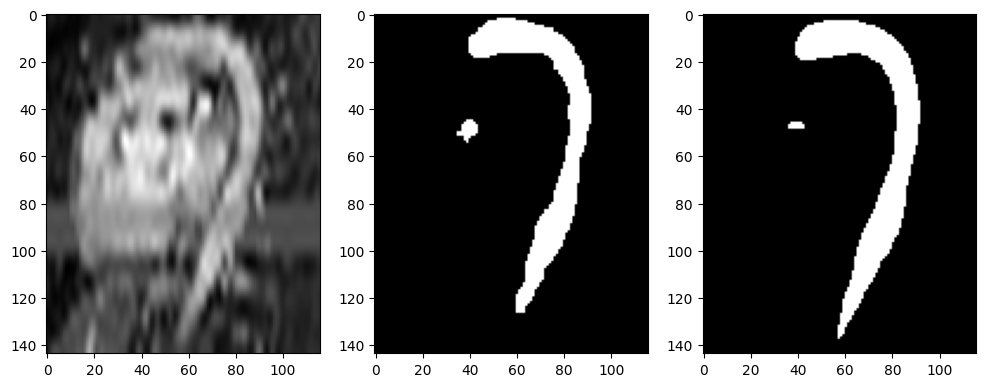

In [24]:
from matplotlib import animation
patient = 'data/Karan_37/2013'
X_test = []
y_test = []
test_gen   = CustomDataGen([patient], 'test').get_gen()
for X, y in test_gen:
    X_test.append(X)
    y_test.append(y)
X_test = np.stack(X_test)
y_test = np.stack(y_test)
y_pred = model.predict(X_test)
y_pred = get_one_hot(np.argmax(y_pred,axis = -1), 3)
fig, axs = plt.subplots(1,3, figsize= (12,6))
i = 0
axs[0].imshow(X_test[i,...,50,0],cmap='gray')
axs[1].imshow(y_test[i,...,50,1],cmap='gray')
axs[2].imshow(y_pred[i,...,50,1],cmap='gray')

In [19]:
#transverse view
for patient in val_patients:
    X_test = []
    y_test = []
    test_gen   = CustomDataGen([patient], 'test').get_gen()
    for X, y in test_gen:
        X_test.append(X)
        y_test.append(y)
    X_test = np.stack(X_test)
    y_test = np.stack(y_test)
    y_pred = model.predict(X_test)
    y_pred = get_one_hot(np.argmax(y_pred,axis = -1), 2)

    fig, axs = plt.subplots(1,2, figsize = (7,5))
    frames = []
    for i in range(y_pred.shape[1]):
        p1 = axs[0].imshow(X_test[0,i,...,0],cmap = 'gray')
        p2 = axs[1].imshow(X_test[0,i,...,0],cmap = 'gray')
        p3 = axs[0].imshow(y_test[0,i,...,-1],alpha=y_test[0,i,...,-1] * 0.7,cmap = 'jet') #ground truth
        p4 = axs[1].imshow(y_pred[0,i,...,-1],alpha = y_pred[0,i,...,-1] * 0.7,cmap = 'Blues') #prediction
        frames.append([p1,p2,p3,p4])
    fig.tight_layout()
    ani = animation.ArtistAnimation(fig, frames)
    ani.save(f"videos/model_35/{patient.split('/')[-1]}.gif", fps=y_pred.shape[1])
    run[f"TrainTV/{patient.split('/')[-1]}"].upload(f"videos/model_35/{patient.split('/')[-1]}.gif")
    plt.close()

1/1 [==============================] - 0s 161ms/step


Test on UKB 200 Good Crops

In [25]:
patients = [pat.replace('.npy','') for pat in glob('data/UKB200Goodcrop/*')] 
train_patients, val_patients = train_test_split(patients,test_size=0.1)


In [3]:
class CustomDataGenTest():    
    def __init__(self, patients,cohort):
        random.shuffle(patients)
        self.patients = patients
        self.cohort = cohort                
    def data_generator(self):
        for patient in self.patients:
            image= np.load(f"{patient}.npy")
            yield normalize(image) #normalising 
    def get_gen(self):
        return self.data_generator()       
def normalize(image):
    mean = np.mean(image)
    std = np.std(image)
    if std != 0:
        norm = (image - mean) / std
    else:
        norm = np.zeros_like(image)
    return norm

In [27]:
patient = patients[8]
X_test = []
test_gen   = CustomDataGenTest([patient], 'test').get_gen()
for X in test_gen:
    X=X[:,:,:,np.newaxis]
    X_test.append(X)
X_test = np.stack(X_test)
X_test.shape

(1, 144, 116, 96, 1)

In [28]:
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

y_pred = model.predict(X_test)
y_pred = get_one_hot(np.argmax(y_pred,axis = -1), 3)

1/1 [==============================] - 0s 148ms/step


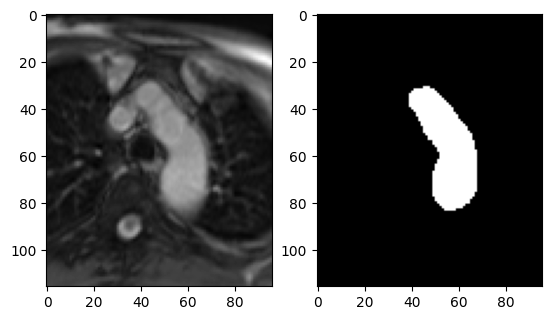

In [29]:
ig, axs = plt.subplots(1,2)

i = 0
axs[0].imshow(X_test[i,25,...,0],cmap='gray')
axs[1].imshow(y_pred[i,25,...,1],cmap='gray')

1/1 [==============================] - 0s 151ms/step


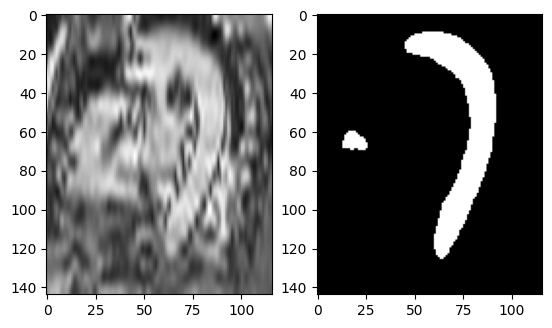

In [30]:
patient = patients[18]
X_test = []
test_gen   = CustomDataGenTest([patient], 'test').get_gen()
for X in test_gen:
    X=X[:,:,:,np.newaxis]
    X_test.append(X)
X_test = np.stack(X_test)
X_test.shape
y_pred = model.predict(X_test)
y_pred = get_one_hot(np.argmax(y_pred,axis = -1), 3)

ig, axs = plt.subplots(1,2)

i = 0
axs[0].imshow(X_test[i,...,60,0],cmap='gray')
axs[1].imshow(y_pred[i,...,60,1],cmap='gray')

In [31]:
from matplotlib import animation
patient = 'data/UKB200Goodcrop/1030585'
X_test = []
test_gen   = CustomDataGenTest([patient], 'test').get_gen()
for X in test_gen:
    X=X[:,:,:,np.newaxis]
    X_test.append(X)
X_test = np.stack(X_test)
y_pred = model.predict(X_test)
y_pred = get_one_hot(np.argmax(y_pred,axis = -1), 2)
fig, ax = plt.subplots(1,1, figsize = (3, 5)) #single plot but using a subplot to call it
frames = []
for i in range(y_pred.shape[-2]):
    p1 = ax.imshow(X_test[0,...,i,0],cmap = 'gray')
    p2 = ax.imshow(y_pred[0,...,i,1],alpha=y_pred[0,...,i,1] * 0.7,cmap = 'jet')
    frames.append([p1,p2])
fig.tight_layout()
ani = animation.ArtistAnimation(fig, frames)
ani.save(f'video.gif', fps=y_pred.shape[-2])
run[f"Wtry/{patient.split('/')[-1]}"].upload('video.gif')
plt.close()


1/1 [==============================] - 0s 149ms/step


In [32]:
patient = 'data/UKB200Goodcrop/1274962'
X_test = []
test_gen   = CustomDataGenTest([patient], 'test').get_gen()
for X in test_gen:
    X=X[:,:,:,np.newaxis]
    X_test.append(X)
X_test = np.stack(X_test)
y_pred = model.predict(X_test)
y_pred = get_one_hot(np.argmax(y_pred,axis = -1), 2)
fig, ax = plt.subplots(1,1, figsize = (3, 5)) #single plot but using a subplot to call it
frames = []
for i in range(y_pred.shape[1]):
    p1 = ax.imshow(X_test[0,i,...,0],cmap = 'gray')
    p2 = ax.imshow(y_pred[0,i,...,1],alpha=y_pred[0,i,...,1] * 0.7,cmap = 'jet')
    frames.append([p1,p2])
fig.tight_layout()
ani = animation.ArtistAnimation(fig, frames)
ani.save(f'video.gif', fps=y_pred.shape[-2])
run[f"WUKBtv200/{patient.split('/')[-1]}"].upload('video.gif')
plt.close()

1/1 [==============================] - 0s 154ms/step


In [33]:
from matplotlib import animation

In [34]:
from skimage.measure import label   

def getLargestCC(segmentation):
    labels = label(segmentation)
    assert( labels.max() != 0 ) # assume at least 1 CC
    largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1
    return largestCC

def clean_mask(mask):
    mask = get_one_hot(np.argmax(mask,axis = -1), 2)
    mask = np.squeeze(mask) #5d to 4d
    mask = mask[...,1] #4d to 3d
    mask = getLargestCC(mask) #clean
    mask = mask[np.newaxis,:,:,:,np.newaxis] #3d to 5d
    return mask

In [35]:
for id in patients: 
    X_test = []
    test_gen= CustomDataGenTest([id], 'train').get_gen()
    for X in test_gen:
        X=X[:,:,:,np.newaxis]
        X_test.append(X)
    X_test = np.stack(X_test)
    y_pred = model.predict(X_test)
    y_pred = clean_mask(y_pred)
    fig, ax = plt.subplots(1,1, figsize = (3, 5)) #single plot but using a subplot to call it
    frames = []
    for i in range(y_pred.shape[-2]):
        p1 = ax.imshow(X_test[0,...,i,0],cmap = 'gray')
        p2 = ax.imshow(y_pred[0,...,i,0],alpha=y_pred[0,...,i,0] * 0.6,cmap = 'jet')
        frames.append([p1,p2])
    fig.tight_layout()
    ani = animation.ArtistAnimation(fig, frames)
    ani.save(f"videos/model_35/{id.split('/')[-1]}.gif", fps=y_pred.shape[-2])
    run[f"UKB200/{id.split('/')[-1]}"].upload(f"videos/model_35/{id.split('/')[-1]}.gif")
    print(id, f"UKB200/model_35/{id.split('/')[-1]}")
    plt.close()

1/1 [==============================] - 0s 160ms/step
data/UKB200Goodcrop/4896701 UKB200/model_35/4896701
1/1 [==============================] - 0s 155ms/step
data/UKB200Goodcrop/4014366 UKB200/model_35/4014366
1/1 [==============================] - 0s 162ms/step
data/UKB200Goodcrop/1634705 UKB200/model_35/1634705
1/1 [==============================] - 0s 155ms/step
data/UKB200Goodcrop/3166651 UKB200/model_35/3166651
1/1 [==============================] - 0s 160ms/step
data/UKB200Goodcrop/2379928 UKB200/model_35/2379928
1/1 [==============================] - 0s 155ms/step
data/UKB200Goodcrop/1286881 UKB200/model_35/1286881
1/1 [==============================] - 0s 159ms/step
data/UKB200Goodcrop/3595863 UKB200/model_35/3595863
1/1 [==============================] - 0s 155ms/step
data/UKB200Goodcrop/2251838 UKB200/model_35/2251838
1/1 [==============================] - 0s 156ms/step
data/UKB200Goodcrop/3598289 UKB200/model_35/3598289
1/1 [==============================] - 0s 156ms/step
da

In [15]:
for id in patients: 
    X_test = []
    test_gen= CustomDataGenTest([id], 'train').get_gen()
    for X in test_gen:
        X=X[:,:,:,np.newaxis]
        X_test.append(X)
    X_test = np.stack(X_test)
    y_pred = model.predict(X_test)
    y_pred = clean_mask(y_pred)
    fig, ax = plt.subplots(1,1, figsize = (3, 5)) #single plot but using a subplot to call it
    frames = []
    for i in range(y_pred.shape[1]):
        p1 = ax.imshow(X_test[0,i,...,0],cmap = 'gray')
        p2 = ax.imshow(y_pred[0,i,...,0],alpha=y_pred[0,i,...,0] * 0.6,cmap = 'jet')
        frames.append([p1,p2])
    fig.tight_layout()
    ani = animation.ArtistAnimation(fig, frames)
    ani.save(f"videos/model_34TV/{id.split('/')[-1]}.gif", fps=y_pred.shape[-2]) #save the gif locally
    run[f"UKB200TV/{id.split('/')[-1]}"].upload(f"videos/model_34TV/{id.split('/')[-1]}.gif") #upload to nepture
    print(id, f"UKB200TV/model_34/{id.split('/')[-1]}") #print the uploaded name
    plt.close()

1/1 [==============================] - 0s 150ms/step
data/UKB200Goodcrop/4896701 UKB200TV/model_34/4896701
1/1 [==============================] - 0s 169ms/step
data/UKB200Goodcrop/4014366 UKB200TV/model_34/4014366
1/1 [==============================] - 0s 154ms/step
data/UKB200Goodcrop/1634705 UKB200TV/model_34/1634705
1/1 [==============================] - 0s 153ms/step
data/UKB200Goodcrop/3166651 UKB200TV/model_34/3166651
1/1 [==============================] - 0s 160ms/step
data/UKB200Goodcrop/2379928 UKB200TV/model_34/2379928
1/1 [==============================] - 0s 160ms/step
data/UKB200Goodcrop/1286881 UKB200TV/model_34/1286881
1/1 [==============================] - 0s 159ms/step
data/UKB200Goodcrop/3595863 UKB200TV/model_34/3595863
1/1 [==============================] - 0s 159ms/step
data/UKB200Goodcrop/2251838 UKB200TV/model_34/2251838
1/1 [==============================] - 0s 162ms/step
data/UKB200Goodcrop/3598289 UKB200TV/model_34/3598289
1/1 [==============================] 

In [37]:
56*3/187

0.8983957219251337

In [31]:
patients = [pat.replace('.npy','') for pat in glob('data/Test_retest_5/*')] 

In [32]:
class CustomDataGenTest():    
    def __init__(self, patients,cohort):
        random.shuffle(patients)
        self.patients = patients
        self.cohort = cohort                
    def data_generator(self):
        for patient in self.patients:
            image= np.load(f"{patient}.npy")
            yield normalize(image) #normalising 
    def get_gen(self):
        return self.data_generator()       
def normalize(image):
    mean = np.mean(image)
    std = np.std(image)
    if std != 0:
        norm = (image - mean) / std
    else:
        norm = np.zeros_like(image)
    return norm

In [48]:
patient = patients[5]
X_test = []
test_gen   = CustomDataGenTest([patient], 'test').get_gen()
for X in test_gen:
    X=X[:,:,:,np.newaxis]
    X_test.append(X)
X_test = np.stack(X_test)
X_test.shape

(1, 204, 192, 256, 1)

In [49]:
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

y_pred = model.predict(X_test)
y_pred = get_one_hot(np.argmax(y_pred,axis = -1), 3)

1/1 [==============================] - 15s 15s/step


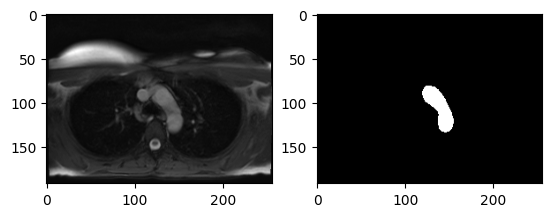

In [51]:
ig, axs = plt.subplots(1,2)

i = 0
axs[0].imshow(X_test[i,65,...,0],cmap='gray')
axs[1].imshow(y_pred[i,65,...,1],cmap='gray')

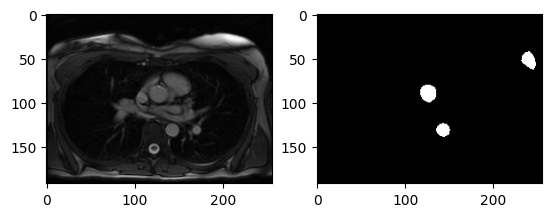

In [52]:
ig, axs = plt.subplots(1,2)

i = 0
axs[0].imshow(X_test[i,105,...,0],cmap='gray')
axs[1].imshow(y_pred[i,105,...,1],cmap='gray')

In [22]:
model_35 = tf.keras.models.load_model(f'models/AOR-35',compile = False)
continue_training = True
model_name = 'AOR-35'

if continue_training:
    run = neptune.init_run(
        project="Aorta/Aorta-raw",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzMjE2ZWMxNi04ZjNkLTRjYjctYWQ1Ni1mY2EyNTU2ZGViYTMifQ==",
        with_id = model_name) 

https://app.neptune.ai/Aorta/Aorta-raw/e/AOR-35


/usr/local/lib/python3.8/dist-packages/neptune/internal/utils/git.py:71: UserWarning: GitPython could not be initialized
  warnings.warn("GitPython could not be initialized")


In [23]:
from skimage.measure import label   

def getLargestCC(segmentation):
    labels = label(segmentation)
    assert( labels.max() != 0 ) # assume at least 1 CC
    largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1
    return largestCC

def clean_mask(mask):
    mask = get_one_hot(np.argmax(mask,axis = -1), 2)
    mask = np.squeeze(mask) #5d to 4d
    mask = mask[...,1] #4d to 3d
    mask = getLargestCC(mask) #clean
    return mask

In [6]:
patients = [pat.replace('.npy','') for pat in glob('data/UKB200Goodcrop/*')] 
train_patients, val_patients = train_test_split(patients,test_size=0.3)
len(val_patients)

57

In [20]:
187*0.9

168.3

In [10]:
for id in val_patients: 
    X_test = []
    test_gen= CustomDataGenTest([id], 'train').get_gen()
    for X in test_gen:
        X=X[:,:,:,np.newaxis]
        X_test.append(X)
    X_test = np.stack(X_test)
    y_pred = model_35.predict(X_test)
    y_pred = clean_mask(y_pred)
    print(y_pred.shape)
    np.save('data/UKBmaskAOR_35/'+id.split('/')[-1]+'.npy', y_pred)

1/1 [==============================] - 0s 149ms/step
(144, 116, 96)
1/1 [==============================] - 0s 149ms/step
(144, 116, 96)
1/1 [==============================] - 0s 148ms/step
(144, 116, 96)
1/1 [==============================] - 0s 149ms/step
(144, 116, 96)
1/1 [==============================] - 0s 149ms/step
(144, 116, 96)
1/1 [==============================] - 0s 147ms/step
(144, 116, 96)
1/1 [==============================] - 0s 149ms/step
(144, 116, 96)
1/1 [==============================] - 0s 149ms/step
(144, 116, 96)
1/1 [==============================] - 0s 149ms/step
(144, 116, 96)
1/1 [==============================] - 0s 150ms/step
(144, 116, 96)
1/1 [==============================] - 0s 149ms/step
(144, 116, 96)
1/1 [==============================] - 0s 148ms/step
(144, 116, 96)
1/1 [==============================] - 0s 148ms/step
(144, 116, 96)
1/1 [==============================] - 0s 148ms/step
(144, 116, 96)
1/1 [==============================] - 0s 148ms/

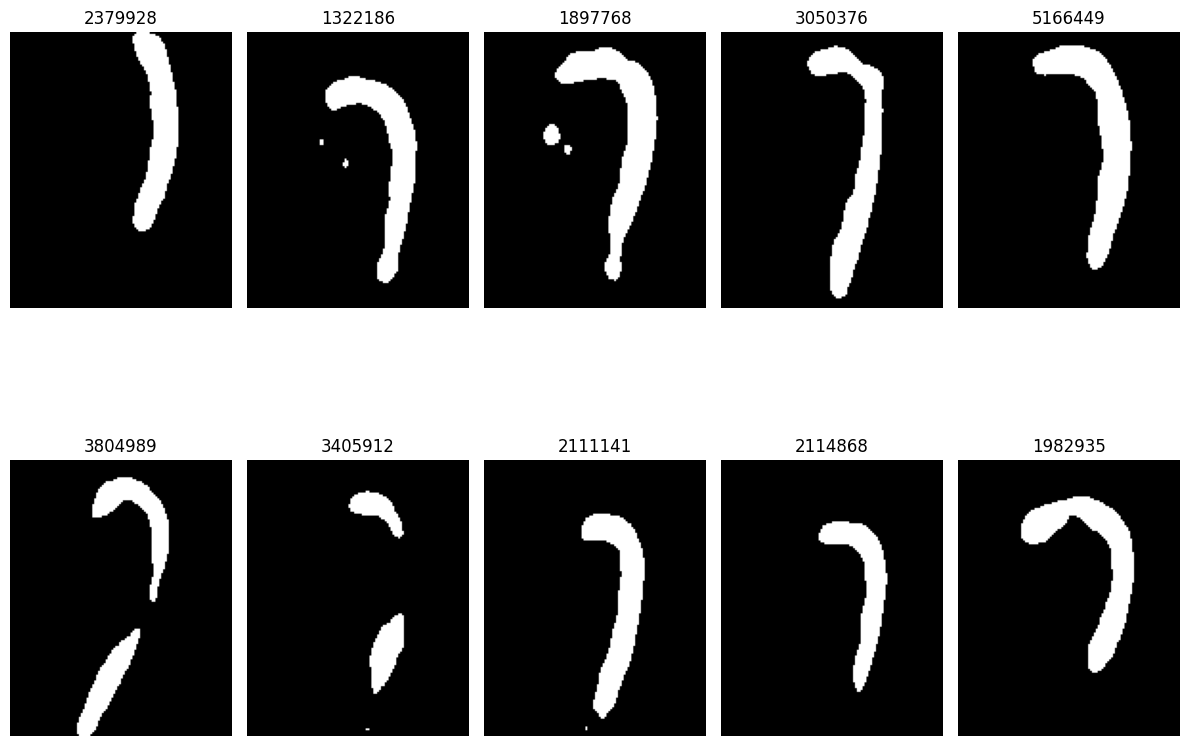

In [17]:
path = '/workspaces/PhD/Unet3D_practice/data/UKBmaskAOR_35/'
dic = os.listdir(path)
img_list = []
for file in dic:
    img = np.load(os.path.join(path, file)) 
    img_list.append(img)
img_names = [os.path.splitext(file_name)[0] for file_name in dic]

fig, axes = plt.subplots(2, 5, figsize=(12, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(img_list[i+30][ :, :, 55], cmap='gray')
    ax.axis('off')
    ax.set_title(img_names[i])

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 149ms/step


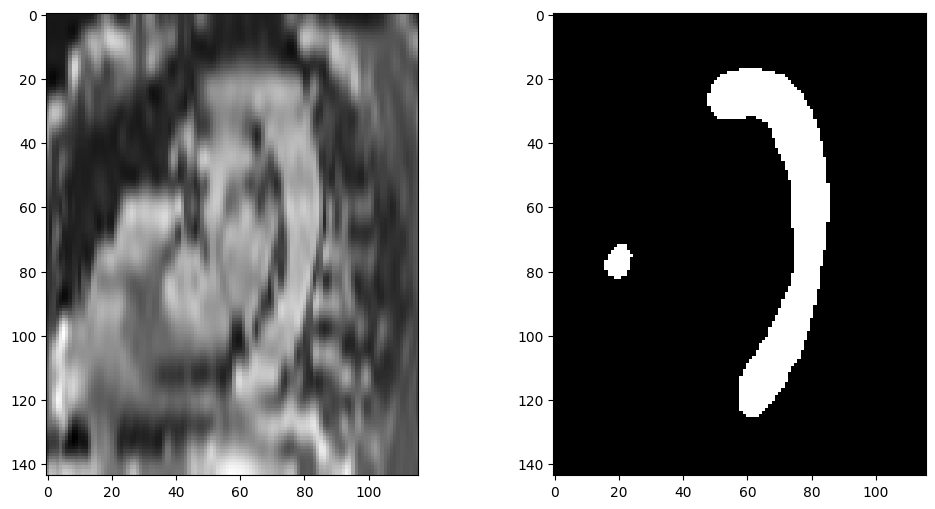

In [33]:
from matplotlib import animation
patient = 'data/UKB200Goodcrop/2040448'
X_test = []
y_test = []
test_gen   = CustomDataGenTest([patient], 'test').get_gen()
for X in test_gen:
    X=X[:,:,:,np.newaxis]
    X_test.append(X)
X_test = np.stack(X_test)
y_pred = model_35.predict(X_test)
y_pred = get_one_hot(np.argmax(y_pred,axis = -1), 3)
fig, axs = plt.subplots(1,2, figsize= (12,6))
i = 0
axs[0].imshow(X_test[i,...,57,0],cmap='gray')
axs[1].imshow(y_pred[i,...,57,1],cmap='gray')

1/1 [==============================] - 0s 149ms/step


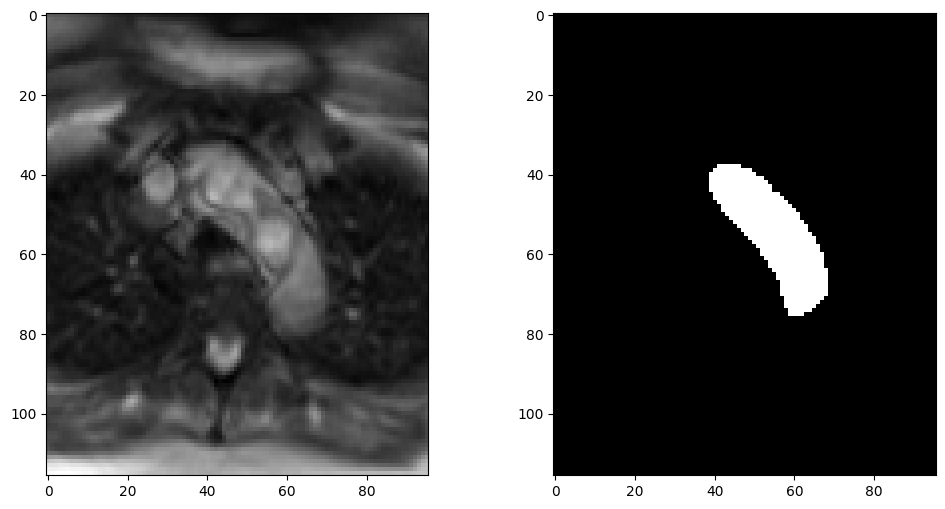

In [42]:
from matplotlib import animation
patient = 'data/UKB200Goodcrop/2699131'
X_test = []
y_test = []
test_gen   = CustomDataGenTest([patient], 'test').get_gen()
for X in test_gen:
    X=X[:,:,:,np.newaxis]
    X_test.append(X)
X_test = np.stack(X_test)
y_pred = model_35.predict(X_test)
y_pred = get_one_hot(np.argmax(y_pred,axis = -1), 3)
fig, axs = plt.subplots(1,2, figsize= (12,6))
i = 0
axs[0].imshow(X_test[i,26,...,0],cmap='gray')
axs[1].imshow(y_pred[i,26,...,1],cmap='gray')

1/1 [==============================] - 0s 148ms/step


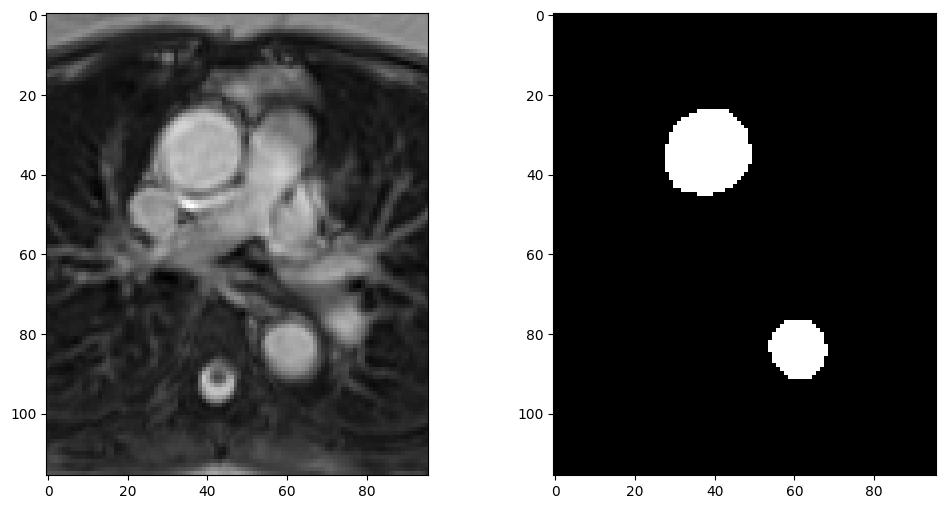

In [48]:
from matplotlib import animation
patient = 'data/UKB200Goodcrop/2699131'
X_test = []
y_test = []
test_gen   = CustomDataGenTest([patient], 'test').get_gen()
for X in test_gen:
    X=X[:,:,:,np.newaxis]
    X_test.append(X)
X_test = np.stack(X_test)
y_pred = model_35.predict(X_test)
y_pred = get_one_hot(np.argmax(y_pred,axis = -1), 3)
fig, axs = plt.subplots(1,2, figsize= (12,6))
i = 0
axs[0].imshow(X_test[i,50,...,0],cmap='gray')
axs[1].imshow(y_pred[i,50,...,1],cmap='gray')

1/1 [==============================] - 0s 148ms/step


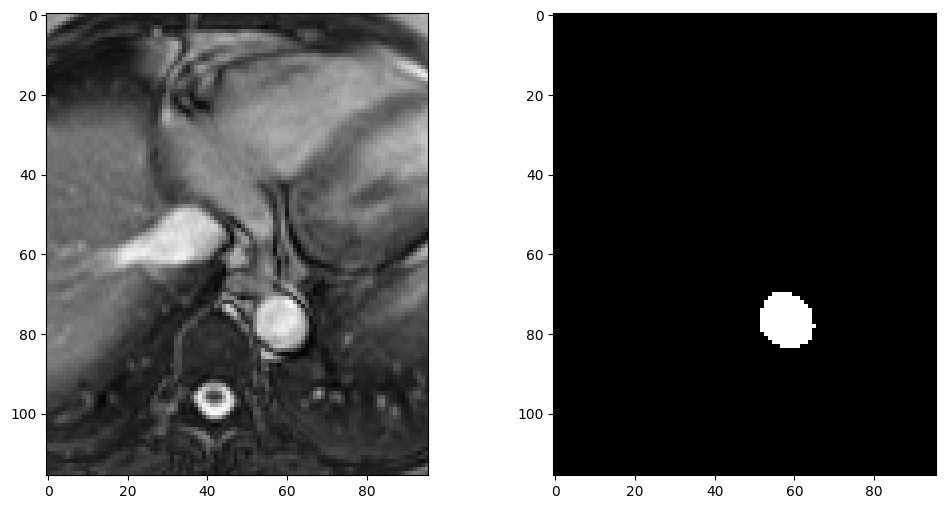

In [49]:
from matplotlib import animation
patient = 'data/UKB200Goodcrop/2699131'
X_test = []
y_test = []
test_gen   = CustomDataGenTest([patient], 'test').get_gen()
for X in test_gen:
    X=X[:,:,:,np.newaxis]
    X_test.append(X)
X_test = np.stack(X_test)
y_pred = model_35.predict(X_test)
y_pred = get_one_hot(np.argmax(y_pred,axis = -1), 3)
fig, axs = plt.subplots(1,2, figsize= (12,6))
i = 0
axs[0].imshow(X_test[i,100,...,0],cmap='gray')
axs[1].imshow(y_pred[i,100,...,1],cmap='gray')